# divide observations into watermasses based on location

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/grid.nc')
obs = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/observations/PNW_obs_compiled.csv')

## remove unnecessary points

In [3]:
len(obs)

2340059

In [4]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
len(obs)

1295566

In [6]:
# depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
len(obs)

1191134

In [8]:
# lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [9]:
len(obs)

1169043

In [10]:
# and honestly i really dont think the washington ecology data or onc data are useful for my purposes
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [11]:
len(obs)

1006797

In [12]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')
# observation count for each source

ios bottle, NCEI PNW
406


ios mooring, ios bottle
9


ooi
50567


NCEI PNW
977


ios bottle
152751


NHL
500073


ios mooring
185224


NCEI Coastal, NHL
10


ios ctd profiles, ios bottle
766


OCNMS
46231


GEOTRACES
383


NCEI Salish
464


ios bottle, NCEI PNW, GEOTRACES
3


ios bottle, GEOTRACES
156


ios ctd profiles
62649


NCEI Coastal
6128




## unit conversion
originally went with the most common choice from observations, but there are some better choices for the sake of the paper

In [13]:
# convert Nstar from umol/kg to mmol/m3 (uM)

# Calculate seawater density using TEOS-10
conservative_temp = gsw.CT_from_t(obs['salinity (g kg-1)'], obs['temperature (degC)'], obs['pressure (dbar)'])
density_seawater = gsw.rho(obs['salinity (g kg-1)'], conservative_temp, obs['pressure (dbar)'])  # Density in kg/m^3
    
# Convert µmol/kg to µmol/L (µM=mmol/m3) using the seawater density
newNstar = obs['Nstar (umol kg-1)'] * (density_seawater / 1000)
obs['Nstar (uM)'] = newNstar

In [14]:
# convert TA, DIC, carbonate from mmol/m3 to umol/kg
    
# Convert µmol/L to µmol/kg using the seawater density
newTA = (obs['TA (uM)'] / density_seawater) * 1000
newDIC = (obs['DIC (uM)'] / density_seawater) * 1000
newCarb = (obs['Carbonate'] / density_seawater) * 1000

obs['TA (umol/kg)'] = newTA
obs['DIC (umol/kg)'] = newDIC
obs['Carbonate (umol/kg)'] = newCarb
    

## dividing based on bathymetry

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

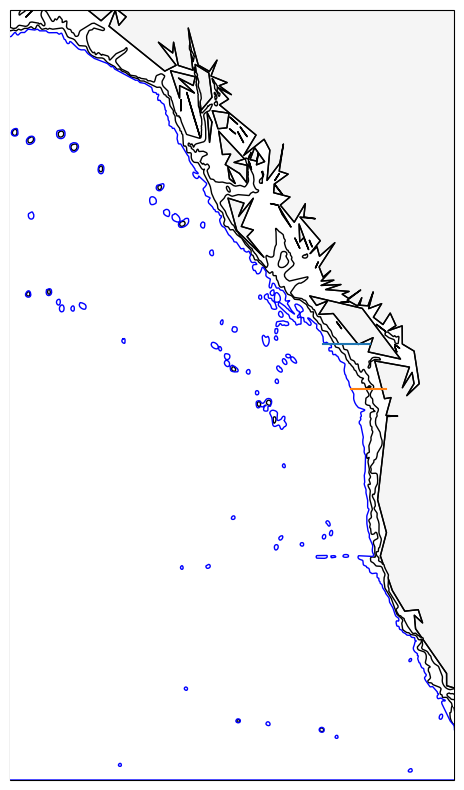

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [38]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("./ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.unary_union)

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [ ]:
# can we do the same for data between the 200 m and 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("./ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.unary_union)

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

In [40]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

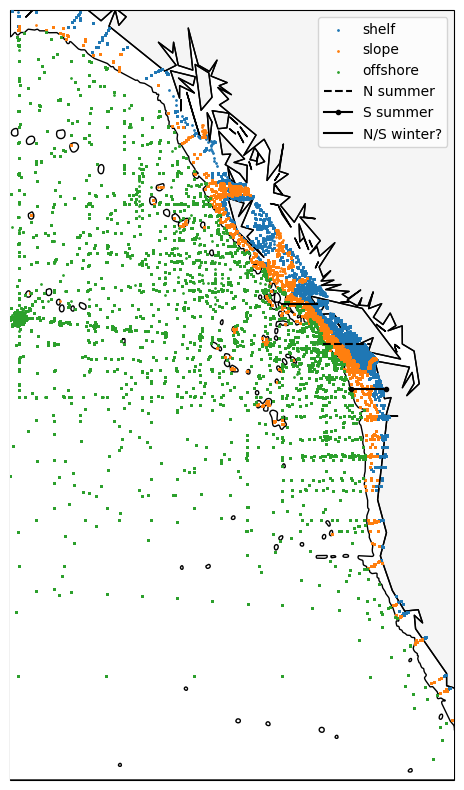

In [41]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()


In [42]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [43]:
# save  obs file with all the data you don't need removed and the location and month columns added
obs.to_csv('./filtered_obs.csv')